In [1]:
!pip install umap leidenalg scanpy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=45dfa4a3f2e0ddfe2eaa4cd3dd2701654af31743006e88de1f6003f36eb0c6bf
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
  Created wheel for session-info: filen

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

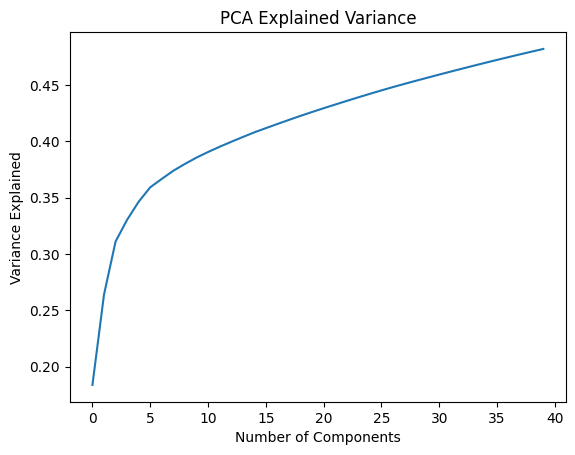

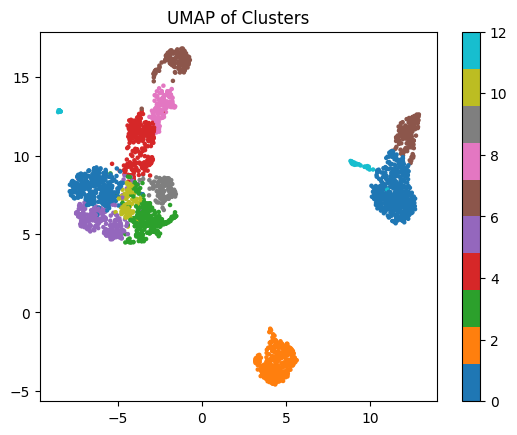

Top marker genes for Cluster 0: ['S100A9', 'CST3', 'TYROBP', 'LYZ', 'LGALS1', 'AIF1', 'LST1', 'FCN1', 'S100A8', 'FCER1G']


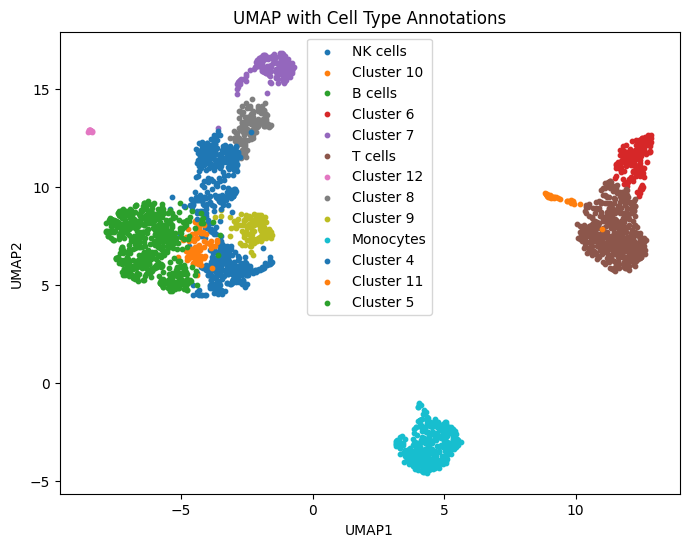

Results saved to annotated_results.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap
import leidenalg
import igraph as ig
from scipy.stats import ttest_ind
import scanpy as sc

# Load the Data using Scanpy
adata = sc.datasets.pbmc3k()

# Convert the AnnData object to a Pandas DataFrame
data = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)

# Preprocessing: Filtering low-quality cells and genes
cell_filter = (data > 0).sum(axis=1) > 200
gene_filter = (data > 0).sum(axis=0) > 3
data = data.loc[cell_filter, gene_filter]

# Normalizing
data = data.div(data.sum(axis=1), axis=0) * 1e4

# Transform
data = np.log1p(data)

# Identify highly variable genes
mean = data.mean(axis=0)
variance = data.var(axis=0)
hvg = (variance / mean).sort_values(ascending=False).index[:2000]
data_hvg = data[hvg]

# PCA
pca = PCA(n_components=40)
pca_result = pca.fit_transform(data_hvg)

# Visualize PCA variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance')
plt.show()

# Clustering
nbrs = NearestNeighbors(n_neighbors=10).fit(pca_result)
distances, indices = nbrs.kneighbors(pca_result)

# Building adjacency graph
graph = ig.Graph()
graph.add_vertices(pca_result.shape[0])
for idx, neighbors in enumerate(indices):
    for neighbor in neighbors:
        graph.add_edges([(idx, neighbor)])

# Leiden clustering
partition = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition)
clusters = np.array(partition.membership)

# UMAP Visualization
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3)
umap_result = reducer.fit_transform(pca_result)

# Plot UMAP
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='tab10', s=5)
plt.colorbar()
plt.title('UMAP of Clusters')
plt.show()

# Marker Gene Identification
cluster_0_cells = data_hvg[clusters == 0]
other_cells = data_hvg[clusters != 0]

marker_genes = {}
for gene in data_hvg.columns:
    t_stat, p_val = ttest_ind(cluster_0_cells[gene], other_cells[gene], equal_var=False)
    marker_genes[gene] = p_val

# Selecting top marker genes for cluster 0
top_marker_genes = sorted(marker_genes, key=marker_genes.get)[:10]
print("Top marker genes for Cluster 0:", top_marker_genes)

cell_types = {0: 'T cells', 1: 'B cells', 2: 'Monocytes', 3: 'NK cells'}  # Example annotations
cluster_annotations = [cell_types.get(c, f'Cluster {c}') for c in clusters]
annotation_df = pd.DataFrame({
    'UMAP1': umap_result[:, 0],
    'UMAP2': umap_result[:, 1],
    'Cluster': clusters,
    'Cell Type': cluster_annotations
})

plt.figure(figsize=(8, 6))
for cell_type in set(cluster_annotations):
    idx = [i for i, ct in enumerate(cluster_annotations) if ct == cell_type]
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=cell_type, s=10)
plt.legend()
plt.title('UMAP with Cell Type Annotations')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

annotation_df.to_csv('annotated_results.csv', index=False)
print("Results saved to annotated_results.csv")